<a href="https://colab.research.google.com/github/Neet-hu/GitBootcampTask/blob/master/fake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing Libraries**

In [ ]:
!pip install opencv-python dlib

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2


--2024-05-15 05:46:23--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.1’

shape_predictor_68_ 100%[===================>]  61.07M  36.4MB/s    in 1.7s    

2024-05-15 05:46:24 (36.4 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2.1’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded = files.upload

**Bar Graph Showing Count of Real and Fake Images**

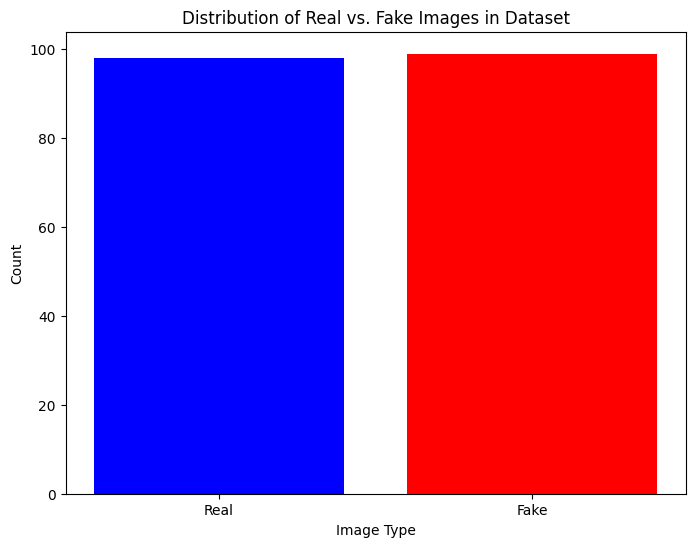

In [ ]:
import matplotlib.pyplot as plt

# Count the number of real and fake images in the dataset
num_real = len(real_images)
num_fake = len(fake_images)

# Plotting the bar graph
labels = ['Real', 'Fake']
counts = [num_real, num_fake]

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['blue', 'red'])
plt.title('Distribution of Real vs. Fake Images in Dataset')
plt.xlabel('Image Type')
plt.ylabel('Count')
plt.show()


**Preprocessing and Training**

In [ ]:

import cv2
import dlib
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Initialize the face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor_path = '/content/shape_predictor_68_face_landmarks.dat'  # Path to the shape predictor file
predictor = dlib.shape_predictor(predictor_path)

def extract_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) > 0:
        face = faces[0]
        landmarks = predictor(gray, face)

        left_eye = np.array([(landmarks.part(36).x, landmarks.part(36).y), (landmarks.part(37).x, landmarks.part(37).y),
                             (landmarks.part(38).x, landmarks.part(38).y), (landmarks.part(39).x, landmarks.part(39).y),
                             (landmarks.part(40).x, landmarks.part(40).y), (landmarks.part(41).x, landmarks.part(41).y)])
        right_eye = np.array([(landmarks.part(42).x, landmarks.part(42).y), (landmarks.part(43).x, landmarks.part(43).y),
                              (landmarks.part(44).x, landmarks.part(44).y), (landmarks.part(45).x, landmarks.part(45).y),
                              (landmarks.part(46).x, landmarks.part(46).y), (landmarks.part(47).x, landmarks.part(47).y)])
        nose = np.array([(landmarks.part(27).x, landmarks.part(27).y), (landmarks.part(28).x, landmarks.part(28).y),
                         (landmarks.part(29).x, landmarks.part(29).y), (landmarks.part(30).x, landmarks.part(30).y)])
        face_dim = (face.right() - face.left(), face.bottom() - face.top())

        return left_eye, right_eye, nose, face_dim
    else:
        return None, None, None, None

def load_and_preprocess_images(folder):
    images = []
    features = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img_resized = cv2.resize(img, (128, 128))
            left_eye, right_eye, nose, face_dim = extract_features(img)
            if left_eye is not None:
                features.append((left_eye, right_eye, nose, face_dim))
                images.append(img_resized)
    return np.array(images), features

# Specify paths to the directories containing real and fake images
real_directory = '/content/drive/MyDrive/Data/Real'
fake_directory = '/content/drive/MyDrive/Data/Fake'

# Load and preprocess real and fake images
real_images, real_features = load_and_preprocess_images(real_directory)
fake_images, fake_features = load_and_preprocess_images(fake_directory)

# Create labels
real_labels = np.ones(len(real_images))
fake_labels = np.zeros(len(fake_images))

# Concatenate images and labels
X = np.concatenate((real_images, fake_images), axis=0)
y = np.concatenate((real_labels, fake_labels), axis=0)

# Normalize pixel values
X = X / 255.0

# Shuffle the data
X, y = shuffle(X, y, random_state=42)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Save the trained model in the recommended Keras format
model.save('/content/drive/MyDrive/trained_model.keras')

Epoch 1/10
5/5 [==============================] - 5s 901ms/step - loss: 1.1379 - accuracy: 0.4894 - val_loss: 0.7616 - val_accuracy: 0.3750
Epoch 2/10
5/5 [==============================] - 5s 839ms/step - loss: 0.7272 - accuracy: 0.4610 - val_loss: 0.6829 - val_accuracy: 0.6250
Epoch 3/10
5/5 [==============================] - 3s 589ms/step - loss: 0.6903 - accuracy: 0.4894 - val_loss: 0.7041 - val_accuracy: 0.3750
Epoch 4/10
5/5 [==============================] - 3s 578ms/step - loss: 0.6844 - accuracy: 0.5532 - val_loss: 0.7260 - val_accuracy: 0.3750
Epoch 5/10
5/5 [==============================] - 3s 665ms/step - loss: 0.6552 - accuracy: 0.6312 - val_loss: 0.7222 - val_accuracy: 0.3750
Epoch 6/10
5/5 [==============================] - 5s 912ms/step - loss: 0.6077 - accuracy: 0.8014 - val_loss: 0.8048 - val_accuracy: 0.3750
Epoch 7/10
5/5 [==============================] - 4s 755ms/step - loss: 0.5768 - accuracy: 0.7589 - val_loss: 0.8313 - val_accuracy: 0.3750
Epoch 8/10
5/5 [====

**Model Evaluation**

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


2/2 - 0s - loss: 0.8331 - accuracy: 0.4750 - 281ms/epoch - 141ms/step
Test Loss: 0.8331209421157837
Test Accuracy: 0.4749999940395355


**Count Real and Fake Images in Training and Test Sets**

In [ ]:
# Count real and fake images in training set
train_real_count = np.sum(y_train == 1)
train_fake_count = np.sum(y_train == 0)

# Count real and fake images in test set
test_real_count = np.sum(y_test == 1)
test_fake_count = np.sum(y_test == 0)


**Visualize Training History**

2/2 [==============================] - 0s 54ms/step


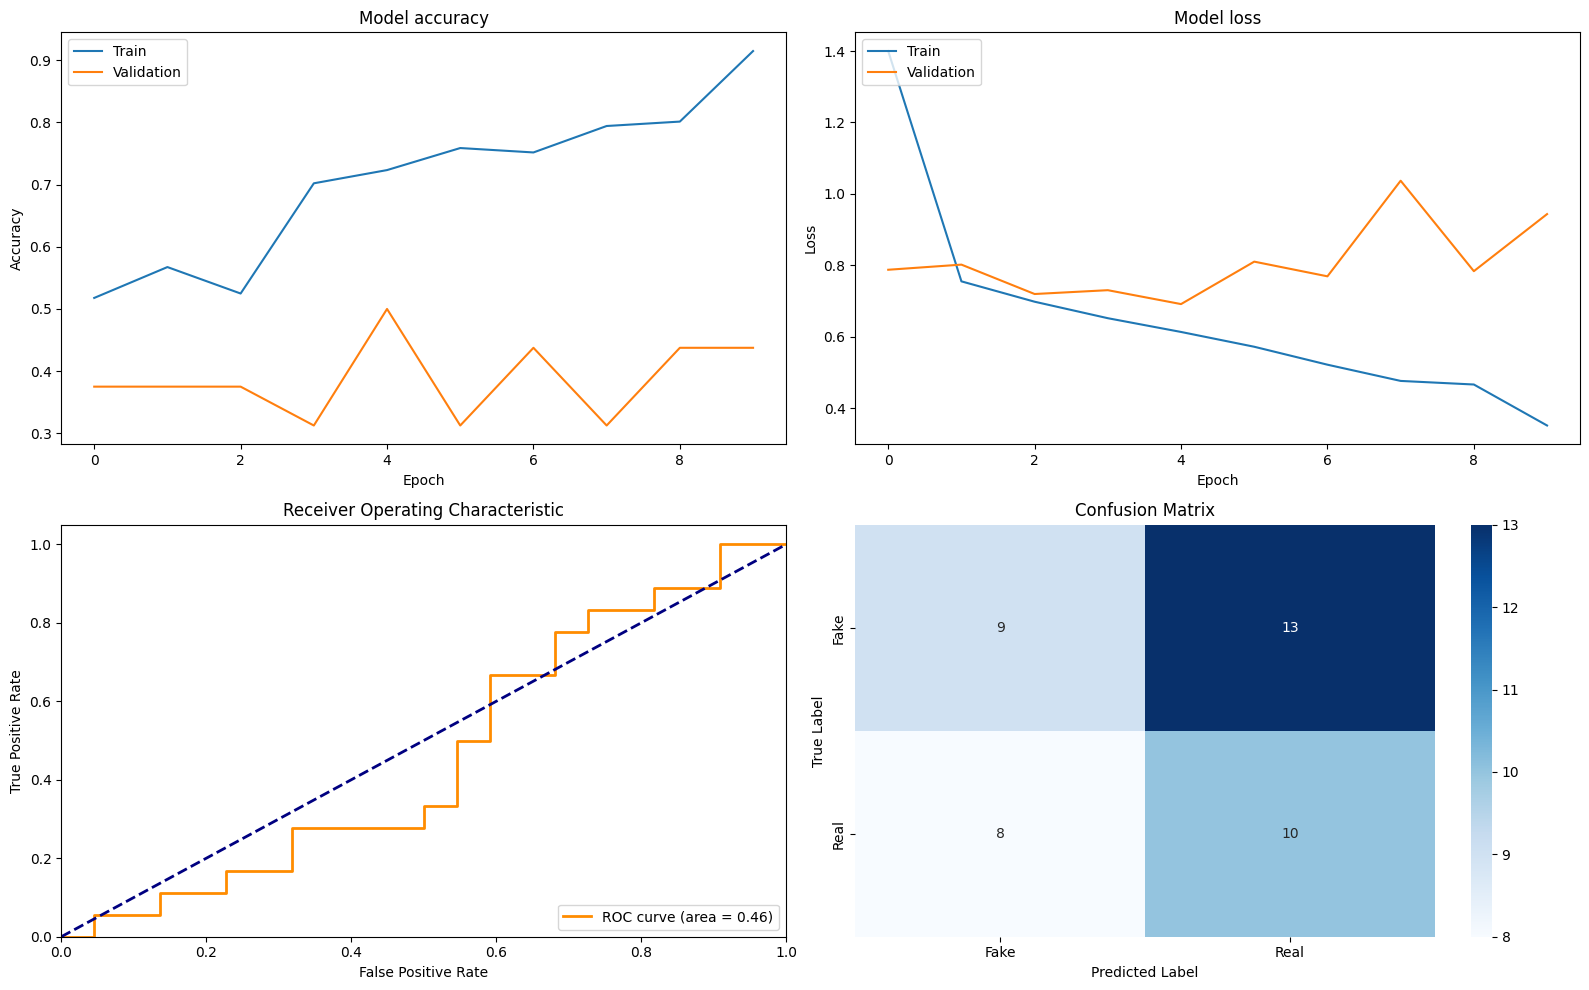

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

# Plot training & validation accuracy values
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# ROC Curve
y_pred_prob = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.subplot(2, 2, 3)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

plt.subplot(2, 2, 4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()


**Generate Predictions**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))


2/2 [==============================] - 0s 41ms/step
Confusion Matrix:
[[ 9 13]
 [ 8 10]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.41      0.46        22
         1.0       0.43      0.56      0.49        18

    accuracy                           0.48        40
   macro avg       0.48      0.48      0.47        40
weighted avg       0.49      0.47      0.47        40



**Predict a Image as Real/Fake**


1/1 [==============================] - 0s 35ms/step
Prediction: 0.6416181921958923
Label: Real


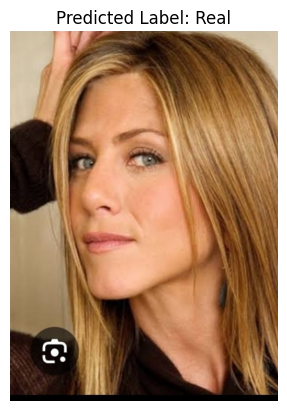

In [ ]:
import matplotlib.pyplot as plt

def preprocess_single_image(image_path):
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f'Image not found: {image_path}')

    # Resize the image
    img_resized = cv2.resize(img, (128, 128))

    # Normalize the image
    img_normalized = img_resized / 255.0

    # Expand dimensions to match the input shape of the model
    img_expanded = np.expand_dims(img_normalized, axis=0)

    return img_expanded

def predict_image(image_path):
    # Preprocess the image
    preprocessed_image = preprocess_single_image(image_path)

    # Make a prediction
    prediction = model.predict(preprocessed_image)

    # Convert prediction to class label
    if prediction < 0.5:
        label = 'Fake'
    else:
        label = 'Real'

    return label, prediction

# Path to a single image (update this path to the actual image path)
single_image_path = '/content/drive/MyDrive/Data/Real/ 28 real.jpeg'  # Replace with your image path


# Predict the image
label, prediction = predict_image(single_image_path)
print(f'Prediction: {prediction[0][0]}')
print(f'Label: {label}')

# Display the image
image = cv2.imread(single_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying correctly in matplotlib
plt.imshow(image)
plt.title(f'Predicted Label: {label}')
plt.axis('off')
plt.show()
